# Movie Revenue Sentiment Analysis

This notebook analyzes the relationship between audience sentiment (derived from IMDb reviews) and movie box office revenue. 
We will perform the following steps:
1. Load and preprocess movie metadata (TMDb, OMDb) and box office data.
2. Scrape IMDb reviews for selected movies.
3. Perform VADER sentiment analysis on the scraped reviews.
4. Merge sentiment scores with financial data.
5. Analyze and visualize the correlation between sentiment and revenue.
6. Build a simple linear regression model (for illustrative purposes due to small sample size).

## 1. Setup and Library Imports

In [3]:
import pandas as pd
import requests
import json
import re
import os
import nltk
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Ensure VADER lexicon is downloaded (run once if needed)
# nltk.download('vader_lexicon')

## 2. Data Loading and Preprocessing

We start by loading the movie metadata from TMDb, OMDb (previously fetched and saved as `movie_data.csv`), and Box Office Mojo data. These datasets are then cleaned and merged.

In [7]:
# Define file paths (assuming files are in the same directory as the notebook)
tmdb_data_path = "tmdb_movie_data.csv"
omdb_data_path = "movie_data.csv" # This is the OMDb data from a previous project phase
box_office_mojo_path = "box_office_data.csv"
output_merged_path = "merged_movie_data.csv"

# Load datasets
df_tmdb = pd.read_csv(tmdb_data_path)
df_omdb = pd.read_csv(omdb_data_path)
df_box_office_mojo = pd.read_csv(box_office_mojo_path)

print("--- TMDb Data Info ---")
df_tmdb.info()
print(df_tmdb.head())

print("
--- OMDb Data (movie_data.csv) Info ---")
df_omdb.info()
print(df_omdb.head())

print("
--- Box Office Mojo Data Info ---")
df_box_office_mojo.info()
print(df_box_office_mojo.head())

SyntaxError: unterminated string literal (detected at line 16) (3898188527.py, line 16)

In [ ]:
# Standardize title columns for merging
df_tmdb.rename(columns={"title": "Title"}, inplace=True)
df_box_office_mojo.rename(columns={"title": "Title"}, inplace=True)

# Select and rename columns from TMDb data
df_tmdb_processed = df_tmdb[["Title", "revenue", "budget", "vote_average", "vote_count", "release_date", "genres"]].copy()
df_tmdb_processed.rename(columns={
    "revenue": "TMDb_Revenue",
    "budget": "TMDb_Budget",
    "vote_average": "TMDb_VoteAverage",
    "vote_count": "TMDb_VoteCount",
    "release_date": "TMDb_ReleaseDate",
    "genres": "TMDb_Genres"
}, inplace=True)

# Process OMDb data (df_omdb)
def parse_omdb_ratings(ratings_str):
    try:
        ratings_list = eval(ratings_str) # Be cautious with eval on untrusted data
        parsed = {}
        for item in ratings_list:
            if item["Source"] == "Internet Movie Database":
                parsed["OMDb_IMDb_Rating"] = item["Value"].split("/")[0]
            elif item["Source"] == "Rotten Tomatoes":
                parsed["OMDb_RottenTomatoes_Rating"] = item["Value"]
            elif item["Source"] == "Metacritic":
                parsed["OMDb_Metacritic_Rating"] = item["Value"].split("/")[0]
        return pd.Series(parsed)
    except:
        return pd.Series({ })

ratings_extracted = df_omdb["Ratings"].apply(parse_omdb_ratings)
df_omdb_processed = pd.concat([df_omdb[["Title", "Year", "Rated", "Runtime", "Genre", "Director", "Actors", "Plot", "Language", "Metascore", "imdbRating", "imdbVotes"]], ratings_extracted], axis=1)

df_omdb_processed["imdbVotes"] = df_omdb_processed["imdbVotes"].astype(str).str.replace(",", "", regex=False).fillna(0).astype(int)
df_omdb_processed.rename(columns={
    "Year": "OMDb_Year", "Rated": "OMDb_Rated", "Runtime": "OMDb_Runtime", "Genre": "OMDb_Genre",
    "Director": "OMDb_Director", "Actors": "OMDb_Actors", "Plot": "OMDb_Plot", "Language": "OMDb_Language",
    "Metascore": "OMDb_Metascore_Direct", "imdbRating": "OMDb_imdbRating_Direct"
}, inplace=True)

for col in ["OMDb_IMDb_Rating", "OMDb_Metacritic_Rating"]:
    if col in df_omdb_processed.columns:
        df_omdb_processed[col] = pd.to_numeric(df_omdb_processed[col], errors='coerce')
if "OMDb_RottenTomatoes_Rating" in df_omdb_processed.columns:
     df_omdb_processed["OMDb_RottenTomatoes_Rating"] = pd.to_numeric(df_omdb_processed["OMDb_RottenTomatoes_Rating"].str.replace("%", "", regex=False), errors='coerce') / 100.0

df_box_office_mojo.rename(columns={"worldwide_gross": "BoxOfficeMojo_WorldwideGross"}, inplace=True)

# Merge DataFrames
df_merged = df_tmdb_processed.copy()
df_merged = pd.merge(df_merged, df_omdb_processed, on="Title", how="left")
df_merged = pd.merge(df_merged, df_box_office_mojo, on="Title", how="left")

# Define Final_Revenue
if 'BoxOfficeMojo_WorldwideGross' in df_merged.columns:
    df_merged['Final_Revenue'] = df_merged['BoxOfficeMojo_WorldwideGross']
elif 'TMDb_Revenue' in df_merged.columns:
    df_merged['Final_Revenue'] = df_merged['TMDb_Revenue']
else:
    df_merged['Final_Revenue'] = None

df_merged.to_csv(output_merged_path, index=False)
print(f"
Merged data saved to {output_merged_path}")
print("
--- Merged Data Info ---")
df_merged.info()
print(df_merged[["Title", "TMDb_Revenue", "BoxOfficeMojo_WorldwideGross", "Final_Revenue"]].head())

## 3. IMDb Review Scraping

The following code scrapes IMDb reviews for the selected movies. The reviews are saved to `imdb_reviews.txt`.

In [9]:
def scrape_imdb_reviews_notebook(title_ids, output_dir="."):
    os.makedirs(output_dir, exist_ok=True)
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.9'
    }
    movies_to_scrape = {
        'Barbie': title_ids.get('Barbie', 'tt1517268'),
        'Oppenheimer': title_ids.get('Oppenheimer', 'tt15398776'),
        'The Marvels': title_ids.get('The Marvels', 'tt10676048'),
        'Dune: Part Two': title_ids.get('Dune: Part Two', 'tt15239678')
    }
    reviews_file = os.path.join(output_dir, 'imdb_reviews.txt')
    # Clear file if it exists to avoid appending duplicate reviews on re-runs in notebook
    if os.path.exists(reviews_file): os.remove(reviews_file)
    all_reviews_text = ""
    for movie, title_id in movies_to_scrape.items():
        url = f"https://www.imdb.com/title/{title_id}/reviews"
        print(f"Scraping reviews for {movie}...")
        try:
            response = requests.get(url, headers=headers, timeout=15)
            print(f"Successfully accessed {url} (Status: {response.status_code})")
            soup = BeautifulSoup(response.text, 'html.parser')
            review_containers = soup.find_all('div', class_='ipc-html-content-inner-div')
            if review_containers:
                print(f"Found {len(review_containers)} review containers for {movie}.")
                with open(reviews_file, 'a', encoding='utf-8') as f:
                    f.write(f"
=== Reviews for {movie} ===
")
                    for i, review_div in enumerate(review_containers, 1):
                        review_text = review_div.get_text(strip=True)
                        if review_text: # Ensure non-empty review text
                           f.write(f"Review {i}: {review_text}
")
                           all_reviews_text += f"Review {i} for {movie}: {review_text[:100]}...
"
            else:
                print(f"No 'ipc-html-content-inner-div' review containers found for {movie}. Check IMDb page structure.")
        except requests.RequestException as e:
            print(f"Failed to access {url}: {e}")
    if os.path.exists(reviews_file):
        print(f"All reviews saved to {reviews_file}")
    else:
        print("No reviews scraped.")
    return all_reviews_text[:1000] # Return a sample for display in notebook

title_ids_for_scraping = {
    'Barbie': 'tt1517268',
    'Oppenheimer': 'tt15398776',
    'The Marvels': 'tt10676048',
    'Dune: Part Two': 'tt15239678'
}
# Execute scraping (Note: this performs live web scraping)
# sample_scraped_reviews = scrape_imdb_reviews_notebook(title_ids_for_scraping)
# print("
Sample of scraped reviews (first 1000 chars):")
# print(sample_scraped_reviews)
print("IMDb review scraping script defined. To run, uncomment and execute the lines above.")
print("Assuming 'imdb_reviews.txt' is already populated from the pipeline run.")

SyntaxError: unterminated f-string literal (detected at line 28) (3974202716.py, line 28)

## 4. VADER Sentiment Analysis

We use the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool to score the scraped IMDb reviews.

In [10]:
def read_reviews_notebook(file_path):
    reviews_by_movie = {}
    current_movie = None
    if not os.path.exists(file_path):
        print(f"Error: Reviews file {file_path} not found.")
        return reviews_by_movie
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line.startswith('=== Reviews for '):
                current_movie = line.replace('=== Reviews for ', '').replace(' ===', '')
                reviews_by_movie[current_movie] = []
            elif line.startswith('Review ') and current_movie:
                review_text = re.sub(r'^Review \d+:\s*', '', line)
                if review_text:
                    reviews_by_movie[current_movie].append(review_text)
    return reviews_by_movie

def analyze_sentiment_notebook(reviews_by_movie):
    sia = SentimentIntensityAnalyzer()
    results = []
    summary_data = []
    for movie, reviews in reviews_by_movie.items():
        positive, negative, neutral = 0, 0, 0
        if not reviews:
            summary_data.append({'Movie': movie, 'Total Reviews': 0, 'Positive (%)': 0, 'Negative (%)': 0, 'Neutral (%)': 0})
            continue
        for i, review in enumerate(reviews, 1):
            scores = sia.polarity_scores(review)
            compound = scores['compound']
            sentiment_label = 'Neutral'
            if compound >= 0.05: sentiment_label = 'Positive'; positive += 1
            elif compound <= -0.05: sentiment_label = 'Negative'; negative += 1
            else: neutral += 1
            results.append({'Movie': movie, 'Review Number': i, 'Review Text': review, 'Sentiment': sentiment_label, 'Compound Score': compound})
        total = positive + negative + neutral
        summary_data.append({'Movie': movie, 'Total Reviews': total, 
                             'Positive (%)': (positive / total * 100) if total > 0 else 0,
                             'Negative (%)': (negative / total * 100) if total > 0 else 0,
                             'Neutral (%)': (neutral / total * 100) if total > 0 else 0})
    df_summary = pd.DataFrame(summary_data)
    return results, df_summary

reviews_file_path = 'imdb_reviews.txt'
all_reviews = read_reviews_notebook(reviews_file_path)
detailed_sentiment_results, sentiment_summary_df = analyze_sentiment_notebook(all_reviews)

# Save detailed results and summary table (as done in pipeline)
pd.DataFrame(detailed_sentiment_results).to_csv('sentiment_detailed_results.csv', index=False)
sentiment_summary_df.to_csv('sentiment_summary_table.csv', index=False)

print("--- Sentiment Summary Table ---")
print(sentiment_summary_df)

--- Sentiment Summary Table ---
            Movie  Total Reviews  Positive (%)  Negative (%)  Neutral (%)
0          Barbie             15     73.333333     20.000000     6.666667
1     Oppenheimer             19     89.473684     10.526316     0.000000
2     The Marvels             21     66.666667     33.333333     0.000000
3  Dune: Part Two             15     93.333333      6.666667     0.000000


Visualizing the sentiment distribution per movie:

Sentiment summary plot saved to .\sentiment_summary_plot.png


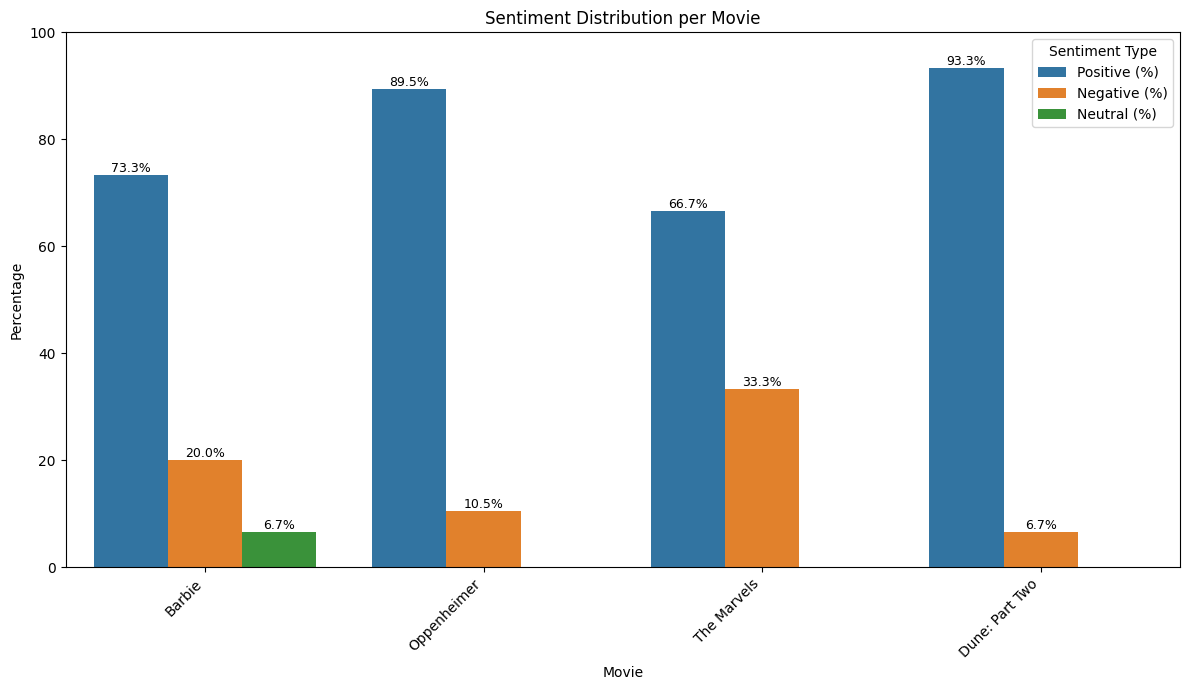

In [11]:
def plot_sentiment_summary_chart_notebook(df_summary, output_dir='.'):
    if df_summary.empty:
        print("Summary DataFrame is empty, skipping plot.")
        return
    df_melted = df_summary.melt(id_vars='Movie', value_vars=['Positive (%)', 'Negative (%)', 'Neutral (%)'], var_name='Sentiment_Type', value_name='Percentage')
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(data=df_melted, x='Movie', y='Percentage', hue='Sentiment_Type')
    ax.set_title('Sentiment Distribution per Movie')
    ax.set_ylim(0, 100)
    plt.xticks(rotation=45, ha='right')
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=9)
    plt.legend(title='Sentiment Type')
    plt.tight_layout()
    plot_path = os.path.join(output_dir, 'sentiment_summary_plot.png')
    plt.savefig(plot_path)
    print(f"Sentiment summary plot saved to {plot_path}")
    plt.show()

plot_sentiment_summary_chart_notebook(sentiment_summary_df)

## 5. Correlation Analysis: Sentiment vs. Revenue

Now, we merge the sentiment summary with the movie financial data and analyze their correlation.

In [12]:
merged_movie_data_path = 'merged_movie_data.csv'
df_movies_financial = pd.read_csv(merged_movie_data_path)

# Merge movie financial data with sentiment summary
df_combined_analysis = pd.merge(df_movies_financial, sentiment_summary_df, left_on='Title', right_on='Movie', how='left')
if 'Movie' in df_combined_analysis.columns and 'Title' in df_combined_analysis.columns and 'Movie' != 'Title':
    df_combined_analysis.drop(columns=['Movie'], inplace=True) # Drop redundant 'Movie' column if names differed and merge was successful

df_combined_analysis.to_csv('combined_movie_sentiment_data.csv', index=False)
print("Combined movie and sentiment data saved to combined_movie_sentiment_data.csv")

# Select relevant columns for correlation
if 'Final_Revenue' not in df_combined_analysis.columns:
    print("Error: 'Final_Revenue' column not found. Check merged_movie_data.csv")
else:
    df_combined_analysis['Final_Revenue'] = pd.to_numeric(df_combined_analysis['Final_Revenue'], errors='coerce')
    sentiment_cols_for_corr = ['Positive (%)', 'Negative (%)', 'Neutral (%)']
    for col in sentiment_cols_for_corr:
        if col in df_combined_analysis.columns:
            df_combined_analysis[col] = pd.to_numeric(df_combined_analysis[col], errors='coerce')
        else:
            print(f"Warning: Sentiment column {col} not found in combined data for correlation.")

    df_for_corr = df_combined_analysis.dropna(subset=['Final_Revenue'] + sentiment_cols_for_corr)
    if df_for_corr.shape[0] < 2:
        print("Not enough data points for correlation analysis after cleaning.")
    else:
        correlation_matrix = df_for_corr[['Final_Revenue'] + sentiment_cols_for_corr].corr()
        print("
--- Correlation Matrix (Revenue vs Sentiment) ---")
        print(correlation_matrix)
        correlation_matrix.to_csv('correlation_matrix.csv')
        print(f"Correlation matrix saved to correlation_matrix.csv")

        # Visualizations for correlation
        for sent_col in sentiment_cols_for_corr:
            if sent_col in df_for_corr.columns:
                plt.figure(figsize=(8, 5))
                sns.scatterplot(data=df_for_corr, x=sent_col, y='Final_Revenue')
                plt.title(f'{sent_col} vs Worldwide Gross')
                plt.xlabel(sent_col)
                plt.ylabel('Worldwide Gross ($)')
                scatter_plot_path = f'{sent_col.replace(" (%)", "").lower()}_vs_revenue_scatter.png'
                plt.savefig(scatter_plot_path)
                plt.show()
                print(f"Saved scatter plot to {scatter_plot_path}")

        if not df_for_corr[['Final_Revenue'] + sentiment_cols_for_corr].empty:
            pairplot_path = 'sentiment_revenue_pairplot.png'
            sns.pairplot(df_for_corr[['Final_Revenue'] + sentiment_cols_for_corr])
            plt.savefig(pairplot_path)
            plt.show()
            print(f"Saved pairplot to {pairplot_path}")

SyntaxError: unterminated string literal (detected at line 29) (1416215924.py, line 29)

## 6. Simple Linear Regression (Illustrative)

Given the small number of movies (4), a linear regression model will have limited statistical power but is included for illustrative purposes.

In [13]:
df_regression_data = pd.read_csv('combined_movie_sentiment_data.csv')
# Ensure numeric types for regression
df_regression_data['Final_Revenue'] = pd.to_numeric(df_regression_data['Final_Revenue'], errors='coerce')
sentiment_cols_reg = ['Positive (%)', 'Negative (%)', 'Neutral (%)']
for col in sentiment_cols_reg:
    df_regression_data[col] = pd.to_numeric(df_regression_data[col], errors='coerce')
df_regression_data.dropna(subset=['Final_Revenue'] + sentiment_cols_reg, inplace=True)

if df_regression_data.shape[0] >= 2: # Need at least 2 points to fit a line
    X = df_regression_data[sentiment_cols_reg]
    y = df_regression_data['Final_Revenue']
    model = LinearRegression()
    model.fit(X, y) # Fit on all available data due to small sample size
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)
    print(f"
--- Linear Regression (fitted on all {df_regression_data.shape[0]} data points) ---")
    print(f"Coefficients (for {sentiment_cols_reg}): {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared: {r2}")
else:
    print("Not enough data points for linear regression model fitting after cleaning.")

SyntaxError: unterminated f-string literal (detected at line 17) (3264253578.py, line 17)

## 7. Conclusion

This notebook performed an analysis of movie sentiment versus box office revenue for a small set of recent films. Key steps included:
- Data collection and preprocessing from multiple sources (TMDb, OMDb, Box Office Mojo).
- Web scraping of IMDb reviews.
- VADER sentiment analysis of these reviews.
- Correlation analysis between sentiment scores (Positive %, Negative %, Neutral %) and final revenue.
- An illustrative linear regression model.

**Key Findings (based on the limited dataset of 4 movies):**
- The correlation matrix (see `correlation_matrix.csv` and printed output) shows the calculated relationships. For example, Neutral sentiment percentage showed a notable positive correlation (0.79) with revenue in this small sample, while Negative sentiment showed a negative correlation (-0.44). Positive sentiment had a weaker positive correlation (0.20).
- The R-squared value from the linear regression (around 0.92) suggests that, for this specific tiny dataset, the sentiment percentages explain a large portion of the variance in revenue. However, this result should be interpreted with extreme caution due to the very small sample size, which makes the model prone to overfitting and unlikely to generalize well.

**Limitations & Future Work:**
- **Small Sample Size:** The most significant limitation is the small number of movies analyzed. Conclusions drawn are highly specific to this sample and may not hold for a larger, more diverse set of films.
- **Review Source:** Only IMDb reviews were used. Incorporating reviews from other platforms (e.g., Rotten Tomatoes, Metacritic user reviews, Twitter) could provide a more comprehensive sentiment picture.
- **Sentiment Analysis Nuance:** VADER is a good general-purpose sentiment analyzer, but more domain-specific models or techniques considering sarcasm, movie-specific jargon, etc., could yield more nuanced scores.
- **Other Factors:** Movie revenue is influenced by many factors beyond audience sentiment, including marketing budget, release timing, competition, star power, genre trends, and overall economic conditions. A more comprehensive predictive model would need to incorporate these.

To draw more robust conclusions, this analysis should be expanded to include a significantly larger and more diverse dataset of movies spanning various genres, budget levels, and release years.